In [1]:
import torch 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
from datasets import*

In [2]:
df = pd.read_parquet('train.parquet')

In [3]:
df = df.drop(['id', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles'], axis=1)
df.head();

In [25]:
df.head()

,molecule_smiles,protein_name,binds
0,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,BRD4,0
1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
2,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,sEH,0
3,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,BRD4,0
4,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,HSA,0


In [5]:
##sample a smaller dataset having same target distribution for binds
class_0 = df[df['binds'] == 0]
class_1 = df[df['binds'] == 1]

In [6]:
sample_size = min(len(class_0), len(class_1)) #balance the dataset
class_0_sample = class_0.sample(n=15000, random_state=42) #use the sample_size
class_1_sample = class_1.sample(n=15000, random_state=42)

In [7]:
balanced_df = pd.concat([class_0_sample, class_1_sample])

In [8]:
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [27]:
len(balanced_df)

30000

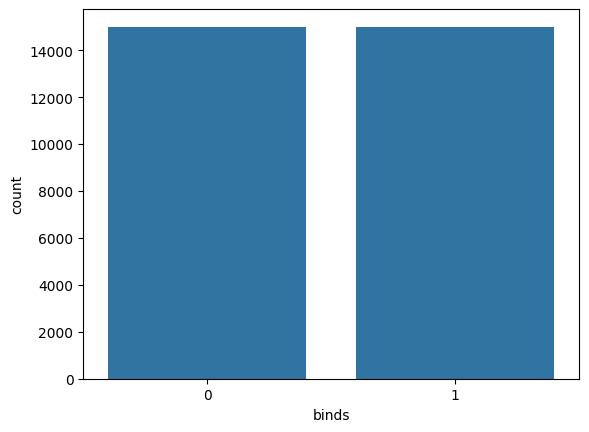

In [26]:
sns.countplot(data=balanced_df, x='binds');

In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [12]:
balanced_df['molecule'] = balanced_df['molecule_smiles'].apply(Chem.MolFromSmiles)

In [13]:
def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))

In [14]:
balanced_df['ecfp'] = balanced_df['molecule'].apply(generate_ecfp)

In [28]:
balanced_df.head()

,molecule_smiles,protein_name,binds,molecule,ecfp
0,O=C1CCCc2ccc(Nc3nc(Nc4ncns4)nc(N[C@H](Cc4ccccc...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x000001B4813...,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,O=C(N[Dy])[C@H](Cc1cccnc1)Nc1nc(Nc2cn[nH]c2)nc...,HSA,1,<rdkit.Chem.rdchem.Mol object at 0x000001B4813...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O=C1CN(CCCNc2nc(NCC3CCC(C(=O)N[Dy])CC3)nc(Nc3c...,sEH,1,<rdkit.Chem.rdchem.Mol object at 0x000001B4813...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CC(C)CC(Nc1nc(NCc2cccc3c2OCO3)nc(Nc2cccc3ncccc...,BRD4,1,<rdkit.Chem.rdchem.Mol object at 0x000001B4813...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O=C(N[Dy])c1ccc(Nc2nc(NCc3cc(C(F)(F)F)co3)nc(N...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x000001B4813...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [17]:
protein_enc = OneHotEncoder(sparse_output=False)
p_names = protein_enc.fit_transform(balanced_df['protein_name'].values.reshape(-1, 1))

In [18]:
X = np.hstack((np.array(balanced_df['ecfp'].values.tolist()), p_names))
y = balanced_df['binds'].values

In [19]:
X 

array([[0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(24000, 1027) (6000, 1027) (24000,) (6000,)


In [21]:
xgbmodel = XGBClassifier()
xgbmodel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
y_pred_probability = xgbmodel.predict_proba(X_test)[:,1] #probability of binding

In [29]:
map_score = average_precision_score(y_test, y_pred_probability)
accuracy = accuracy_score(y_test, xgbmodel.predict(X_test))
print(f'MAp score: {map_score:.2f}, Accuracy: {accuracy}')

MAp score: 0.96, Accuracy: 0.898


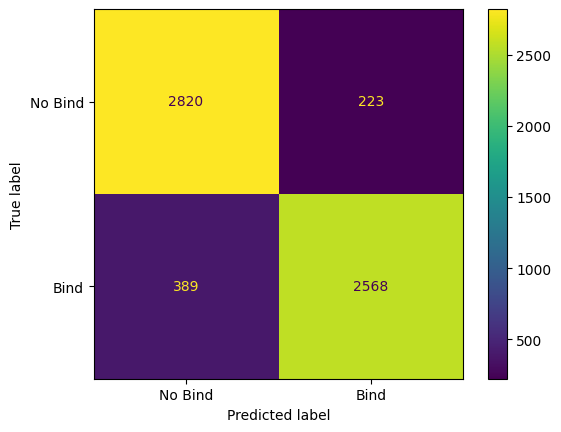

In [30]:
cm = confusion_matrix(y_test, xgbmodel.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Bind', 'Bind'])
disp.plot();
plt.show();

In [31]:
balanced_df.head()

,molecule_smiles,protein_name,binds,molecule,ecfp
0,O=C1CCCc2ccc(Nc3nc(Nc4ncns4)nc(N[C@H](Cc4ccccc...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x000001B4813...,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,O=C(N[Dy])[C@H](Cc1cccnc1)Nc1nc(Nc2cn[nH]c2)nc...,HSA,1,<rdkit.Chem.rdchem.Mol object at 0x000001B4813...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O=C1CN(CCCNc2nc(NCC3CCC(C(=O)N[Dy])CC3)nc(Nc3c...,sEH,1,<rdkit.Chem.rdchem.Mol object at 0x000001B4813...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CC(C)CC(Nc1nc(NCc2cccc3c2OCO3)nc(Nc2cccc3ncccc...,BRD4,1,<rdkit.Chem.rdchem.Mol object at 0x000001B4813...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O=C(N[Dy])c1ccc(Nc2nc(NCc3cc(C(F)(F)F)co3)nc(N...,sEH,0,<rdkit.Chem.rdchem.Mol object at 0x000001B4813...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [64]:
balanced_df.to_csv('balanced_dataset.csv', index=False)